In [1]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *


class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망

    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]


In [2]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from deep_convnet import DeepConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

train loss:2.3209546073298877
=== epoch:1, train acc:0.176, test acc:0.187 ===
train loss:2.402639357879208
train loss:2.2799379224797267
train loss:2.2808486668829557
train loss:2.2721298288621528
train loss:2.255336987507969
train loss:2.286202111245256
train loss:2.2888819540224326
train loss:2.2343980037658855
train loss:2.2679451958072816
train loss:2.2528494258869927
train loss:2.245147117946139
train loss:2.246317363310013
train loss:2.236777098137173
train loss:2.245997074374474
train loss:2.156292726976549
train loss:2.225294380063191
train loss:2.1802798442882905
train loss:2.169758616781231
train loss:2.2682559876262904
train loss:2.2382977327475975
train loss:2.0987033563796156
train loss:2.0696572938159012
train loss:2.140746788857936
train loss:2.1311160704644956
train loss:2.1260607771736257
train loss:2.1932786267349225
train loss:2.096724555135687
train loss:2.0806409763266425
train loss:2.245197720439289
train loss:2.1113640288788487
train loss:1.959900419231036
train

train loss:1.1120459848417676
train loss:1.2631715085048345
train loss:1.2600226468959352
train loss:1.253232179874941
train loss:1.176889464367606
train loss:1.1589622485123539
train loss:1.340385472156272
train loss:1.1689687950993581
train loss:1.0472635631106129
train loss:1.0421406112791756
train loss:1.2459160154014781
train loss:1.2255574337347332
train loss:1.4338522237615754
train loss:1.2430837620694493
train loss:1.2735088777550314
train loss:1.1616030856495663
train loss:1.3353657036210018
train loss:1.071079075131267
train loss:1.2346143523411142
train loss:1.0844269310573775
train loss:1.0422414732585477
train loss:1.2837404023595715
train loss:1.120263334335923
train loss:1.1457785134107124
train loss:1.1893026592307279
train loss:1.2658943855495866
train loss:1.230524438507672
train loss:1.1583201330582116
train loss:1.2285803476080246
train loss:1.0453786706336
train loss:1.2624829409531193
train loss:1.336405619720742
train loss:1.2208762533769708
train loss:0.9130341

train loss:1.0155861068278906
train loss:0.9505900629206643
train loss:1.084217310399633
train loss:1.0056818495318225
train loss:0.9393426277091835
train loss:1.0430815353076046
train loss:1.2405168499904065
train loss:1.1255925445306532
train loss:0.9227369742949273
train loss:1.0851106023839023
train loss:1.0708367127956024
train loss:1.0911483419480141
train loss:1.1192512547261875
train loss:1.1867195872356886
train loss:1.0976817140576367
train loss:0.8399893448896202
train loss:0.9639991393166462
train loss:1.0941321373850266
train loss:1.0545806916656162
train loss:0.9632489820589097
train loss:0.9827018175488001
train loss:1.1085560319815952
train loss:1.3908802814464283
train loss:1.1773201316163526
train loss:1.0291732489931082
train loss:1.0952333981390907
train loss:1.108998176376342
train loss:0.9560599522183787
train loss:1.0617765234393581
train loss:1.0666384794725645
train loss:0.984665570689331
train loss:1.0431096760536784
train loss:1.0479028714622145
train loss:0.

train loss:0.9498687286892574
train loss:0.9835878526389
train loss:1.0190244242054043
train loss:1.02427628305391
train loss:1.0217347953792295
train loss:1.0598198430491994
train loss:0.999881949534967
train loss:1.147028390863633
train loss:1.0800188553299748
train loss:0.9268930859481564
train loss:1.12809019193976
train loss:1.0386240296476945
train loss:0.9221320134841118
train loss:0.8523505266669684
train loss:0.8920243822666472
train loss:1.0600823129670358
train loss:0.9600783581734308
train loss:1.1027688555879418
train loss:1.0255472752656003
train loss:1.0604898303064203
train loss:0.9547416312632637
train loss:0.7900207172260533
train loss:0.8467541329927166
train loss:1.0845180281265738
train loss:1.0436906134426664
train loss:0.9296865550480014
train loss:1.0405172405560854
train loss:1.0856436665665523
train loss:0.8480670904968939
train loss:1.067405564410658
train loss:1.117043271359649
train loss:1.1136086917852348
train loss:1.0083550846072777
train loss:1.14579186

train loss:1.0695086965189606
train loss:0.9995600401188323
train loss:0.9472637368703108
train loss:1.1273802443481957
train loss:0.9130657277506389
train loss:0.955167091208229
train loss:1.0325789774576286
train loss:1.0154696690589533
train loss:1.0184058333910024
train loss:1.063471115990785
train loss:0.8859235692790383
train loss:1.0597851629920059
train loss:0.8899521797006926
train loss:0.7753758628318317
train loss:0.8282060873886461
train loss:0.88946922947478
train loss:1.0156655631182736
train loss:0.9686191545754456
train loss:0.958470330212053
train loss:1.025203926611145
train loss:0.8195046931126336
train loss:0.8008429538284431
train loss:0.8424133424699801
train loss:1.0959227036933408
train loss:0.8330020665930499
train loss:0.8651157292150292
train loss:1.203100987947985
train loss:0.8107080064041403
train loss:0.7850756439462448
train loss:1.118285946996887
train loss:1.041850362613321
train loss:0.925769838985153
train loss:0.98342889889058
train loss:0.936606297

train loss:0.935156324729925
train loss:1.0268545789634855
train loss:1.0697860668159331
train loss:0.7810479875652502
train loss:0.9795375582333571
train loss:0.860451834588794
train loss:0.9630964376483355
train loss:0.957041330550291
train loss:0.9510361847980587
train loss:0.7751296614975272
train loss:0.9473436214945355
train loss:1.0113138701382742
train loss:1.3052808710004047
train loss:1.0502787757563623
train loss:0.8681736082109349
train loss:0.8753664493332758
train loss:0.7950309676474275
train loss:0.915680406625137
train loss:0.9612240037247143
train loss:0.83956512237047
train loss:0.9526531956100218
train loss:0.8171171007590532
train loss:0.8805500054971951
train loss:0.9963805036046206
train loss:0.8404670082979966
train loss:0.8633240750246882
train loss:0.9718176924555043
train loss:0.890946415934858
train loss:0.9801782620418555
train loss:0.7823031549761211
train loss:0.7824283034686471
train loss:0.8868639981422046
train loss:0.8637658316406798
train loss:0.8433

train loss:0.9380250896314688
train loss:0.8548630649583363
train loss:0.9539577757335789
train loss:0.8762903047739676
train loss:0.915876342150458
train loss:1.1253906223700954
train loss:0.8798001349789348
train loss:0.9886538490210259
train loss:0.9165184988878444
train loss:0.8599276927245445
train loss:0.8690600258955604
train loss:0.9422319550394468
train loss:1.0250779614637073
train loss:0.9376886544978918
train loss:0.8370009844619137
train loss:0.9655319064691937
train loss:0.8206025448627708
train loss:1.0151596885640657
train loss:0.8116228902902397
train loss:0.8859152622657875
train loss:0.9608200079282588
train loss:0.9774529056340863
train loss:0.9745508246155373
train loss:0.9559669717355592
train loss:1.0179838498503964
train loss:0.8150439556468051
train loss:1.0039760878040682
train loss:0.8969456742960881
train loss:1.0790744233364016
train loss:0.8365643103151761
train loss:0.8390972769045968
train loss:0.984856312834358
train loss:0.9759132327627662
train loss:0

train loss:1.0676773021261767
train loss:0.7716232719713976
train loss:0.7369502402865551
train loss:0.9536026243372538
train loss:0.8230717369076954
train loss:0.8706397196898026
train loss:0.8745247116630515
train loss:0.9032660781610983
train loss:1.0401792873154203
train loss:1.0082597021101511
train loss:0.8330148136179111
train loss:0.748839234628373
train loss:1.0019860663729951
train loss:0.9317180514753101
train loss:0.9929646540286103
train loss:0.9903778094661807
train loss:1.0647818836421714
train loss:0.9313226323490333
train loss:0.8678721667608
train loss:1.0387947645647009
train loss:0.8895805829575404
train loss:0.9069557297306554
train loss:1.0577074172601568
train loss:0.9963143061181227
train loss:0.9945353692956392
train loss:0.8590395146590423
train loss:0.9229276052344172
train loss:0.8152254193649761
train loss:0.8602359108065692
train loss:0.8749490129359261
train loss:0.990687705961002
train loss:0.9937936389170453
train loss:0.9297658460272222
train loss:1.08

train loss:0.9221275751854856
train loss:0.9241882143990001
train loss:0.8505383424488515
train loss:0.9082448052609444
train loss:0.7736958596910387
train loss:0.9273956868425272
train loss:1.1519412316602504
train loss:0.9401456082657098
train loss:1.055050713293707
train loss:0.8042387100961891
train loss:0.8768987851099813
train loss:0.903370269847914
train loss:1.1198759377280787
train loss:0.8459257690665721
train loss:0.9020797503024558
train loss:0.9483897383690766
train loss:0.746752107126145
train loss:1.029838827187173
train loss:0.9086616857892573
train loss:0.7650995051216001
train loss:0.9947548556768452
train loss:0.8595681617507342
train loss:0.94165653321185
train loss:0.8923826828130327
train loss:0.9482834874258299
train loss:0.932171780548433
train loss:0.8806582285660857
train loss:0.9039980578953027
train loss:1.080527730007511
train loss:0.9391605664548761
train loss:1.0870331407365015
train loss:0.9521347613151389
train loss:0.9377983535089688
train loss:0.72924

train loss:0.9138703595455893
train loss:0.9033176276350787
train loss:0.8296064568174377
train loss:0.8446989971411841
train loss:0.9653702331185702
train loss:0.9039872185780043
train loss:0.8806681887452678
train loss:0.9103151586303079
train loss:0.8982268532540675
train loss:0.9462444283456773
train loss:0.9332573428859382
train loss:0.994020939594457
train loss:0.9829937589288938
train loss:0.7748164277025635
train loss:0.832879063115822
train loss:1.1508099880668559
train loss:0.841081093410541
train loss:0.8053243280403994
train loss:0.8203942510660981
train loss:0.7300562348622897
train loss:0.8535532660203485
train loss:0.9643225254592356
train loss:0.9481763404087116
train loss:0.9933402713891275
train loss:1.103744266520789
train loss:0.786123807504923
train loss:1.0332689204912424
train loss:0.8831528151852583
train loss:0.9057451890051764
train loss:1.0426272971989956
train loss:0.9068831031537391
train loss:0.8294343506455394
train loss:1.0177081836936608
train loss:0.89

train loss:0.9435702503482932
train loss:0.8685005491397232
train loss:0.8031967371933344
train loss:0.8787500169912533
train loss:1.163361495245293
train loss:0.8860893671465024
train loss:0.9804132272935858
train loss:0.8985184769407634
train loss:0.9518262684780895
train loss:1.0736140539714434
train loss:0.7466981358060361
train loss:0.7746561870951552
train loss:0.9644551186998213
train loss:0.8840078363149451
train loss:0.8388342737087582
train loss:0.7314176135279143
train loss:0.9237416346914665
train loss:1.0376564635067262
train loss:0.8774404875644152
train loss:0.9693596372064651
train loss:0.7638347026809074
train loss:0.9778115134783125
train loss:0.8196323143656098
train loss:0.9260928876154945
train loss:1.1097133701362565
train loss:0.7884386606789126
train loss:1.0067747073902578
train loss:0.9622071164235239
train loss:0.8584463161113821
train loss:0.7517575991263449
train loss:1.0243508326462503
train loss:0.9790703709309304
train loss:0.8228600108020578
train loss:

train loss:1.0142954227889422
train loss:0.6971299353236572
train loss:1.0593041209146028
train loss:0.8713232865525997
train loss:0.8911020010007802
train loss:0.91347082669535
train loss:0.876454193677207
train loss:0.9020843667052031
train loss:0.8862534050166979
train loss:0.9072166735864703
train loss:0.9101421612259629
train loss:0.942499170036274
train loss:0.8288732468567295
train loss:0.9198908438807443
train loss:0.8943925056200938
train loss:0.795641134525002
train loss:0.6956641396270475
train loss:0.8224057773681726
train loss:1.0212239606290878
train loss:0.8468221208085105
train loss:0.874642914009018
train loss:0.9739584361274889
train loss:1.0484232466160257
train loss:0.9583209268838191
train loss:0.8694037862702284
train loss:1.0064222539707757
train loss:0.9766250978082479
train loss:1.0987548897493395
train loss:0.8749391837963786
train loss:0.9989388361541656
train loss:1.0318641841828908
train loss:0.9912566852059419
train loss:1.0361465698291739
train loss:0.962

train loss:0.8861167906738229
train loss:1.118998597294448
train loss:0.8778354008481607
train loss:0.8104802493160325
train loss:0.9134158144655043
train loss:0.9202340237844223
train loss:1.0067670428154896
train loss:0.8976672480186213
train loss:0.9253091290361207
train loss:0.8822334256920703
train loss:0.9502300141962712
train loss:1.0230994150644188
train loss:0.8095537757170215
train loss:1.0629119808649365
train loss:0.8956647020288924
train loss:1.0309406160173178
train loss:0.9158411629512281
train loss:1.0412795209197894
train loss:0.705118089892995
train loss:0.8546090880487064
train loss:1.044529290463131
train loss:0.8548526841580201
train loss:0.8525061198690641
train loss:0.9412762242447507
train loss:0.9703077042600609
train loss:0.9452734470408651
train loss:0.9629785958819014
train loss:1.0046692318624324
train loss:0.8281536568741094
train loss:1.0429348939155592
train loss:0.9190095889881941
train loss:0.7461910005041864
train loss:1.0066624531169084
train loss:0.

train loss:0.9598158936783832
train loss:0.8518702623392096
train loss:0.8516297479099219
train loss:0.9847163894144326
train loss:0.9333042459708001
train loss:1.0221750885490122
train loss:0.8748914473853624
train loss:0.8911785248897341
train loss:0.9499697233420283
train loss:0.8699970272025028
train loss:0.9865148984135866
train loss:0.9701753868071505
train loss:0.7963024994052299
train loss:0.9685140053109172
train loss:0.7776110208665701
train loss:0.9657699080581321
train loss:0.9956134114176878
train loss:0.6979715880771107
train loss:0.9753407735296713
train loss:0.8634882542704954
train loss:0.9212544132138006
train loss:0.862263461045996
train loss:0.8418158640556841
train loss:0.8968592395061071
train loss:0.7289899101084752
train loss:0.9240928210828789
train loss:0.8824617769253764
train loss:0.8644390722153524
train loss:0.8099411394166768
train loss:0.8684218371598642
train loss:0.9249963971032975
train loss:0.8838016511094007
train loss:0.9315230568665583
=== epoch:7

train loss:0.7963398699411092
train loss:0.911402592152072
train loss:0.8870255025379405
train loss:0.9430922001733595
train loss:0.7481166703416773
train loss:0.9227671039591692
train loss:1.0546070527900262
train loss:0.8498080362566327
train loss:0.8521672970725875
train loss:0.9456109803834264
train loss:0.7743481354563617
train loss:0.8398928355276428
train loss:0.8807745089279535
train loss:0.9351078590726946
train loss:0.8375793986747104
train loss:0.9088215327210841
train loss:0.8273554530697328
train loss:1.1212904327006559
train loss:1.0240772838314292
train loss:0.8309185428515048
train loss:0.9852854110592311
train loss:0.8902814430449111
train loss:0.8370110796190667
train loss:0.8261105061766914
train loss:0.7249324353345046
train loss:1.0097470027935311
train loss:0.8528772277897158
train loss:0.835921287848401
train loss:0.9980139936828533
train loss:1.0263481592683525
train loss:0.9532987196157156
train loss:0.9450422813787226
train loss:1.0461015634960416
train loss:0

train loss:0.7338165882647822
train loss:0.932713936040193
train loss:0.7985394348743565
train loss:0.8087818165147909
train loss:1.0075146914896347
train loss:1.0579912425277964
train loss:0.9386081732721381
train loss:0.7029213983922626
train loss:0.9341390137273285
train loss:0.9004317011546762
train loss:0.7829960720248549
train loss:1.0821641866001688
train loss:0.7960541908297479
train loss:0.6837438286592898
train loss:1.1473843722586903
train loss:0.8961549932408543
train loss:0.6421131606652444
train loss:0.729640281443944
train loss:0.7374038565104207
train loss:0.8808189968762088
train loss:0.8218154175552206
train loss:0.9209553402285944
train loss:1.030914327476189
train loss:0.8732767121788886
train loss:0.7509115728913197
train loss:1.102656102593084
train loss:0.8692055252839692
train loss:0.8999159848901673
train loss:1.0188403879437344
train loss:0.8303319450820272
train loss:0.8918070551056239
train loss:0.8533538131652311
train loss:0.9420467501574799
train loss:0.8

train loss:0.8923147953709885
train loss:0.8420334872931527
train loss:1.0313198765901712
train loss:0.9495707375132548
train loss:1.0231646588857695
train loss:0.9845113467267761
train loss:0.7792903382659793
train loss:0.7566700143766225
train loss:0.8545533986344886
train loss:0.703651688344915
train loss:0.8634816609506079
train loss:0.9019033222334997
train loss:0.9528773762614315
train loss:0.9023943157884774
train loss:0.8382841160658471
train loss:0.633148467128475
train loss:0.9051352378664131
train loss:0.8652845368015051
train loss:1.0028184844909993
train loss:0.945490968134419
train loss:0.8661828685866986
train loss:0.8647938978825578
train loss:0.9418181412576235
train loss:0.8933653370057546
train loss:0.8859490485006551
train loss:0.829348296504623
train loss:0.8214718369322922
train loss:0.9644593885744617
train loss:0.7331781824163071
train loss:0.9296513054876379
train loss:0.9082302748923836
train loss:0.8546125096505796
train loss:0.9109528065140797
train loss:0.9

train loss:0.8365176736496766
train loss:1.0085245619701708
train loss:0.9369134687435211
train loss:0.8536044567934337
train loss:0.941992285482713
train loss:0.8139049483989866
train loss:0.9160148291581058
train loss:0.7205496516769321
train loss:0.880956196233583
train loss:0.7813545830839154
train loss:0.946843673925411
train loss:0.8561960212701081
train loss:0.9833299789068758
train loss:0.7970467422691612
train loss:0.940767651612568
train loss:0.8360045942788489
train loss:0.8373038565258818
train loss:0.8610652970227959
train loss:0.7918158501992493
train loss:0.7711078083517121
train loss:0.9696089830117718
train loss:0.8560027179762081
train loss:0.7910728486537786
train loss:0.8655767191383009
train loss:0.8714031905456726
train loss:0.9813005650646732
train loss:0.940429186424931
train loss:0.8618685416043195
train loss:0.9780174444137073
train loss:0.8901795817045172
train loss:0.9225650799479201
train loss:0.7973548993667786
train loss:1.0054667992797925
train loss:0.83

train loss:0.9740458219033045
train loss:0.5827070552972966
train loss:0.9419988028822821
train loss:0.93350620676226
train loss:0.7356852995386474
train loss:0.9302938084144552
train loss:0.8131573797061056
train loss:0.8276250723187166
train loss:0.8088514622519325
train loss:0.8153616270898648
train loss:0.8117806538373062
train loss:0.8356669254913668
train loss:0.8450084252261888
train loss:0.9156774275364599
train loss:0.7825027733624609
train loss:1.046654819348759
train loss:0.8830914609483416
train loss:0.7041818945308893
train loss:1.0022547871378789
train loss:0.8196828291275833
train loss:0.8298127546227324
train loss:0.7198865803497455
train loss:0.9634692513137267
train loss:0.8063131408757528
train loss:0.9991245753741205
train loss:0.9180135574844279
train loss:0.9228688999594894
train loss:0.9111523919796389
train loss:0.9728170200617899
train loss:0.86706912223138
train loss:0.9233796431045594
train loss:1.0487696336811025
train loss:0.9547106975308539
train loss:0.87

train loss:0.7302481820257121
train loss:0.8820840227759811
train loss:0.9311717585849953
train loss:0.9321503508986255
train loss:0.8430232322805722
train loss:0.8787407459426833
train loss:0.8881378603819524
train loss:0.7883327237218932
train loss:0.7054250247078002
train loss:0.8716230205796299
train loss:0.8389202824870474
train loss:0.8528318648803556
train loss:0.8784851253910927
train loss:1.1977116392868998
train loss:0.8570582917671061
train loss:0.876274070193495
train loss:0.984701979581324
train loss:0.8748363355253893
train loss:0.8199771276603316
train loss:0.991473350065031
train loss:0.7805963237319525
train loss:0.9149969009225543
train loss:1.1318675528548803
train loss:1.0590240983125083
train loss:0.8480541630623415
train loss:0.8258520659166619
train loss:0.9568693659434377
train loss:0.9449978560727363
train loss:0.847679102866152
train loss:0.9967343613101798
train loss:0.7542067805313306
train loss:0.9308231274088447
train loss:0.7657946764871549
train loss:0.7

train loss:0.8895838159860348
train loss:0.7950144153980565
train loss:0.9124642935378736
train loss:0.7302267459406244
train loss:0.779484457486183
train loss:0.7294985778855184
train loss:0.8657967121730026
train loss:0.7683035969350632
train loss:0.9409564004650233
train loss:0.8008659413373355
train loss:0.8487975783330264
train loss:0.7326484657753902
train loss:0.8696951818206549
train loss:0.8301323529214565
train loss:0.7832781527663428
train loss:0.7736858565138662
train loss:0.9390758496241102
train loss:0.9945816681177125
train loss:0.8607032305187649
train loss:0.9073144619330813
train loss:0.9234239948006707
train loss:0.7655714754414474
train loss:0.9527288793318808
train loss:0.707024432062636
train loss:0.8067438819772005
train loss:0.9126301393829808
train loss:0.9889738353059663
train loss:0.7002805989343757
train loss:0.7918071677509302
train loss:0.8533428480041553
train loss:0.8919967139529412
train loss:1.0901895765670708
train loss:0.7641025009585924
train loss:0

train loss:0.8977128737399847
train loss:0.7627787650995212
train loss:0.8414314307572311
train loss:0.8234645814140903
train loss:1.0315253186187423
train loss:0.9693995435727737
train loss:1.0231999290659797
train loss:0.8286017058307885
train loss:0.9252567111606917
train loss:0.8870289051112508
train loss:0.8564767890357586
train loss:0.9993989206687313
train loss:0.8248706309182681
train loss:0.9351234688245357
train loss:0.9456611358513543
train loss:0.9476467471493929
train loss:0.9337196869017896
train loss:0.7889047867640244
train loss:0.894036259119133
train loss:0.9846819118048825
train loss:0.8317283967732944
train loss:0.8912256805999305
train loss:0.8326692406029198
train loss:0.9133665220332545
train loss:0.8708453883214304
train loss:0.8789789205235289
train loss:0.9706027225316322
train loss:0.5533896051735462
train loss:0.9388429767111398
train loss:0.8889995974104556
train loss:0.8542066277187916
train loss:0.857570775028687
train loss:0.7906615105332164
train loss:1

train loss:0.880663461735099
train loss:0.8227827666172786
train loss:1.0419008887763632
train loss:0.7715543795563217
train loss:0.7879583148480751
train loss:0.8922668374003031
train loss:0.8747453604948354
train loss:0.9228214383947985
train loss:0.8367057983579953
train loss:0.8425624326705368
train loss:0.833659810386365
train loss:1.026353724309175
train loss:0.9814067634977272
train loss:0.7458104114980477
train loss:0.8236207046146586
train loss:0.9305579651345697
train loss:0.9891419588424345
train loss:0.9893366233985804
train loss:0.8080511662997659
train loss:0.9826000186522008
train loss:0.9529074148059976
train loss:0.9157114001313934
train loss:0.8434211324276594
train loss:0.858467496170493
train loss:0.8772641972887213
train loss:0.7541763915116924
train loss:0.8870224670137635
train loss:0.7593385502507597
train loss:0.8711100134165206
train loss:0.8564543783582776
train loss:0.8265921706514306
train loss:0.7976370043074346
train loss:0.7549223912156273
train loss:0.8

train loss:0.7622821418432362
train loss:0.9400194352240279
train loss:1.091182601313444
train loss:0.7737150566966376
train loss:0.9714645984470966
train loss:0.8503356217284883
train loss:0.7783853617690801
train loss:0.8097167449905375
train loss:0.7498809125240126
train loss:0.7038757379736923
train loss:0.8673478780488385
train loss:0.9360989742745681
train loss:0.7385054884844542
train loss:0.887682552268725
train loss:0.9643759045918914
train loss:0.9846244930568965
train loss:1.0579359681148637
train loss:0.8123700383101168
train loss:0.7794464814089305
train loss:0.7656388713223555
train loss:0.8404419874018219
train loss:0.9283752779413704
train loss:0.7462085249805916
train loss:0.8727045893305814
train loss:0.9600465635040739
train loss:0.710562041030079
train loss:1.0551431011100727
train loss:0.9526618000877548
train loss:0.9404254151585514
train loss:0.9979422264782117
train loss:1.0177701125203937
train loss:0.9671664499374022
train loss:1.0085385482770166
train loss:0.

train loss:0.9471184673578528
train loss:0.8725825081438866
train loss:0.8396085203587446
train loss:0.9251862913650684
train loss:0.9598664708899399
train loss:0.739356646895294
train loss:0.9015189583719965
train loss:0.9042352662700479
train loss:0.8656227679203955
train loss:0.6910898293275928
train loss:0.9286016117143866
train loss:0.930894540532694
train loss:0.8689975979157782
train loss:0.936513227167731
train loss:0.8853834552849648
train loss:0.8802623988372376
train loss:0.9028308530027448
train loss:0.95442258064807
=== epoch:12, train acc:0.994, test acc:0.989 ===
train loss:0.734975010874877
train loss:1.1365550730804281
train loss:0.7722058609965596
train loss:0.7341452992820617
train loss:0.9283129948265468
train loss:0.84383807041426
train loss:0.8398107291851707
train loss:0.9336178612998637
train loss:0.7025254982854373
train loss:0.9073516707460559
train loss:0.944887692720246
train loss:0.7825534615100992
train loss:0.8747466750550831
train loss:0.7924777680555836

train loss:0.8260637102733642
train loss:0.9310941368457826
train loss:0.8140903276060295
train loss:0.8605504865839022
train loss:0.8102943399501696
train loss:0.9817197912510852
train loss:0.6862755682307646
train loss:0.9320752182250845
train loss:0.9772495038030289
train loss:1.083497928555019
train loss:0.8437664318168315
train loss:0.8942196189861705
train loss:0.7728392772056688
train loss:0.8245451632050045
train loss:1.0274768412017448
train loss:0.8432532588054523
train loss:0.9671841259792768
train loss:0.9285411641389709
train loss:0.8339350700871383
train loss:0.9095537131853046
train loss:0.7910153696686466
train loss:0.8653106188316118
train loss:0.9555844452967392
train loss:0.8611316094410971
train loss:0.8755358685851362
train loss:0.7551283368998721
train loss:0.7511996110481506
train loss:0.7766443578404213
train loss:0.9163748386261227
train loss:1.006246061429674
train loss:0.7806579800478782
train loss:0.8867633888695459
train loss:0.9374356784824159
train loss:0

train loss:0.907990793003379
train loss:0.865495630933409
train loss:0.8267132864792771
train loss:0.8228074450086389
train loss:1.1030191586814213
train loss:0.7805951237604668
train loss:0.9424490042854162
train loss:0.8717188232129276
train loss:0.9623528920864927
train loss:0.826232445620536
train loss:0.9748519130672437
train loss:0.8225406653910404
train loss:0.9120668886862235
train loss:0.8697967406547353
train loss:0.7107902582810145
train loss:0.9090877292101933
train loss:0.9549200694483001
train loss:0.8342492656040027
train loss:0.8576640966003722
train loss:1.0044652246893166
train loss:0.925780780890589
train loss:0.6977253279136033
train loss:0.7813453446934854
train loss:0.937883372914264
train loss:0.8842173730974777
train loss:0.8831509647887971
train loss:0.7665450822564055
train loss:0.8067011885369172
train loss:0.9650295659275986
train loss:0.8226129562638311
train loss:0.9614117855259876
train loss:0.835938316022339
train loss:0.9116331039467583
train loss:0.782

train loss:1.0127077883504787
train loss:0.9384484010576785
train loss:1.1261630817124217
train loss:0.8699337583215643
train loss:0.8248372041604044
train loss:0.906656627282505
train loss:0.8447304042190492
train loss:0.8059812382072233
train loss:0.8592915088832436
train loss:0.8780830186360501
train loss:0.9308513247292641
train loss:0.9351004566783381
train loss:0.766919315236258
train loss:0.99496642428389
train loss:0.9701970735312596
train loss:0.9867378120059733
train loss:0.7168376370356586
train loss:0.9196435576400048
train loss:0.957561032529928
train loss:0.8898784358119957
train loss:0.9671762117761595
train loss:1.1692802651366625
train loss:1.010066202513225
train loss:0.8432554758261149
train loss:0.9642012872494253
train loss:0.8139267723587739
train loss:0.942328138530732
train loss:0.8616431477383862
train loss:1.1553530891339656
train loss:0.858988248212481
train loss:0.8892249931670082
train loss:0.9791295616177674
train loss:0.8577181230538286
train loss:0.67367

train loss:0.7225615805128527
train loss:0.7976663383877236
train loss:0.887942848108295
train loss:0.9739696191318995
train loss:0.8270097655797136
train loss:0.7705943767477699
train loss:0.9862025381801897
train loss:0.928433598991106
train loss:0.8864595940569348
train loss:0.9079174617402406
train loss:0.8550765599265233
train loss:0.7118489315148099
train loss:0.7847031958010685
train loss:0.9913985871986851
train loss:0.8766856008273187
train loss:1.0113655358850218
train loss:0.9192739834623892
train loss:0.7526681419439025
train loss:0.7546087358630932
train loss:0.9935922727649843
train loss:0.9613460056753526
train loss:0.8080198473996194
train loss:0.9222228240014405
train loss:0.9091766194106531
train loss:0.8871406553697337
train loss:0.8487585373027318
train loss:0.9535515008322258
train loss:0.8576151919328094
train loss:0.9816663900944717
train loss:0.9029566219766245
train loss:0.8284955509038334
train loss:0.7352178816112506
train loss:0.9309459302519886
train loss:0

train loss:0.8468599798614197
train loss:0.9604985547494543
train loss:0.8834905941191689
train loss:0.8385495969954713
train loss:0.9535682907558205
train loss:0.8633583445762865
train loss:0.8982029397135176
train loss:0.7908496694309473
train loss:0.8473597379552187
train loss:0.839284342147623
train loss:0.8203636367599974
train loss:0.8408525838945082
train loss:0.7367254992871843
train loss:0.754195278853905
train loss:0.8806905372849583
train loss:0.8902677581728422
train loss:0.7945213338777327
train loss:0.831567713490928
train loss:0.7627243937269554
train loss:0.8845536429756911
train loss:0.9043216833427618
train loss:0.9210113554230449
train loss:0.9285900655050601
train loss:0.9252547770788468
train loss:0.8826759984665961
train loss:0.7309722091301663
train loss:0.6642615675826938
train loss:0.8389813779765596
train loss:0.9339487829707253
train loss:0.9820681845337178
train loss:0.8601117380510591
train loss:0.8433253764991998
train loss:0.9222579642407304
train loss:0.

train loss:0.895040695613622
train loss:1.010951718131123
train loss:1.0430112214646383
train loss:0.8728539576768215
train loss:1.0301178667306494
train loss:1.003629277328494
train loss:0.7745208007601855
train loss:0.7365606492115857
train loss:0.8171651408379579
train loss:0.7370288057453773
train loss:0.9480741881474235
train loss:0.7628926693726065
train loss:1.0651685454303341
train loss:0.9057617500602326
train loss:0.8821364113802268
train loss:0.8842869663956355
train loss:0.8309964785079292
train loss:0.9937113502474044
train loss:0.873701616479931
train loss:0.8263532327605312
train loss:0.9188350994189168
train loss:0.6704251588333545
train loss:1.0498381612367573
train loss:0.9232435151523791
train loss:0.9840631865476407
train loss:0.8384738929029167
train loss:0.8626058636667484
train loss:0.8630999003254872
train loss:0.8531344943629281
train loss:1.0060298798189007
train loss:0.8594422004760238
train loss:0.8947543785078013
train loss:0.8329695606013153
train loss:0.7

train loss:0.9339507618524991
train loss:0.7644244383304907
train loss:0.7720839498942317
train loss:0.87946807277468
train loss:0.8688288631940736
train loss:0.8416788218719313
train loss:0.9387919989405225
train loss:0.8353629016311973
train loss:0.7900197047823105
train loss:0.7529876608620196
train loss:0.9669442588834339
train loss:0.8994921672667071
train loss:0.8631547484055179
train loss:0.9113807778837055
train loss:1.0496376139623578
train loss:0.9634754114289179
train loss:0.8149613610335865
train loss:0.8526429847751094
train loss:0.8914328086038583
train loss:0.830707943814542
train loss:0.787007015499935
train loss:1.0465410108533635
train loss:1.0028199090149945
train loss:0.8264981843599288
train loss:0.7353352032406852
train loss:0.9019616806933284
train loss:0.9295819982101176
train loss:0.8151033307362101
train loss:0.9388304660831733
train loss:0.7897268098407885
train loss:0.9149692287513096
train loss:0.966005658932326
train loss:0.8073058366048858
train loss:0.94

train loss:0.8995654874852606
train loss:0.9324664206915629
train loss:0.8767834599877642
train loss:0.8774396072586687
train loss:0.8925366810109777
train loss:0.9632253368471986
train loss:0.8763464366731972
train loss:0.8423478521196409
train loss:0.8062944792153637
train loss:0.7541596211821031
train loss:0.84817278952242
train loss:0.9664603780887241
train loss:0.9255468795600887
train loss:0.8875647675849769
train loss:0.8803013540178791
train loss:0.9043764158247256
train loss:0.7264903540870532
train loss:0.9696723652696135
train loss:0.7495820784713352
train loss:0.8018714029835239
train loss:0.7900805128524385
train loss:0.8828938474437972
train loss:0.9279810983584547
train loss:0.7907161553514956
train loss:0.6237765857327057
train loss:0.905572866364831
train loss:0.8163929765537772
train loss:0.8761344306622721
train loss:0.8295362841899799
train loss:0.877931775514528
train loss:0.9020922199803776
train loss:0.866618329224476
train loss:0.6402506740761228
train loss:0.81

train loss:0.7837484106325985
train loss:0.9237651164506725
train loss:0.8991830202144024
train loss:1.0334291990639979
train loss:0.6680290252549294
train loss:1.083330794454062
train loss:0.9920262273665353
train loss:0.9358602537608404
train loss:0.8805789147784922
train loss:0.9864657726990401
train loss:0.9481309496318596
train loss:1.0055381956894411
train loss:0.7717970080152722
train loss:1.0459443948343334
train loss:1.0418449439766386
train loss:0.983178060085683
train loss:0.7976068576137573
train loss:0.9727886949970608
train loss:0.9151344124058283
train loss:0.9402394233800578
train loss:0.6460024580633851
train loss:0.925852308315208
train loss:1.0584683038710387
train loss:0.9122356407105227
train loss:0.9008138833243396
train loss:0.7429550355431835
train loss:0.8574016231766108
train loss:0.9641714001896321
train loss:0.8655388160794207
train loss:0.9139614397258704
train loss:0.8175391414849765
train loss:1.093406906395878
train loss:0.8342015010913735
train loss:0.8

train loss:0.9111660301108633
train loss:0.8300446139535714
train loss:0.9451041395459153
train loss:0.9359137826042793
train loss:0.8677584611522912
train loss:0.7788169264779167
train loss:0.709280260271984
train loss:0.8268926217631452
train loss:0.8525270783447528
train loss:0.7245622595277795
train loss:0.9614417813594384
train loss:0.9079104739119953
train loss:0.7979703579197621
train loss:0.8267469885886869
train loss:0.8773112979720598
train loss:1.0479130706601107
train loss:1.037816866543603
train loss:0.8860087445482496
train loss:0.711878509158915
train loss:0.7308628178264598
train loss:0.6653653458360185
train loss:0.9274437004456404
train loss:0.7167763516448576
train loss:0.7137972964258826
train loss:0.7497720842386738
train loss:0.9043870370318284
train loss:0.9440507322095748
train loss:0.8790232596009407
train loss:0.7935481078507288
train loss:0.7372569089056646
train loss:0.9454025744115817
train loss:0.8166641148121073
train loss:0.9095459545274626
train loss:0.

train loss:0.8382810180737631
train loss:0.9126446581346968
train loss:0.9486325668278635
=== epoch:17, train acc:0.996, test acc:0.991 ===
train loss:0.9844119843914854
train loss:0.7413870956930951
train loss:0.9298570842575653
train loss:0.59655405302548
train loss:0.8994273307915835
train loss:0.8713068728053013
train loss:0.8823731949659305
train loss:1.0150493406236476
train loss:0.9033579034293677
train loss:0.8291939430244571
train loss:0.9191972084522692
train loss:0.8923703227937804
train loss:0.9117188147949652
train loss:1.0004472617986753
train loss:0.9239726688177423
train loss:0.9661837476627612
train loss:0.8019975366995108
train loss:0.9089184938603484
train loss:0.6947183460806856
train loss:0.9847597379116847
train loss:0.7769778662240365
train loss:0.8635426482854733
train loss:0.8965960717135036
train loss:1.0256371122498031
train loss:0.8944336373084678
train loss:0.9232048672618441
train loss:0.8226775942631122
train loss:0.7827037305450113
train loss:0.887673669

train loss:0.7725201877164057
train loss:0.9056023896903893
train loss:0.7016713759368575
train loss:0.8584882012224203
train loss:0.9804151073632213
train loss:1.0225484074987379
train loss:0.760669795553539
train loss:0.793561178815078
train loss:0.8041070418788605
train loss:0.9427300440387453
train loss:0.7769476880390542
train loss:0.8532776024501139
train loss:0.9016335084440685
train loss:0.8857878805035565
train loss:0.7444784076289517
train loss:0.8189442940781096
train loss:0.6763336773594655
train loss:0.8814530141473661
train loss:0.9434090145410329
train loss:0.968725800210644
train loss:0.7850567031153816
train loss:0.8546831417017766
train loss:0.7019131005317755
train loss:0.7602825731891025
train loss:0.8038455834267354
train loss:0.7974973345108287
train loss:0.97633071099386
train loss:0.8502731303845313
train loss:0.8977686376722849
train loss:0.9286253671147121
train loss:0.8484560390743877
train loss:0.9609888191963304
train loss:0.9317547082253423
train loss:0.71

train loss:0.8944676646257791
train loss:1.071413497209204
train loss:0.8916539147856253
train loss:0.8423137979076825
train loss:0.8020338722986244
train loss:0.9860649864766944
train loss:0.8630427927899887
train loss:0.8107789384427341
train loss:0.8426716922090549
train loss:0.6424584682492593
train loss:0.935266528617618
train loss:0.8131785388568946
train loss:0.9660554382206118
train loss:0.7750031021391959
train loss:0.7956253846999377
train loss:0.8575064144294922
train loss:0.8510519878395683
train loss:0.721730024655767
train loss:0.9278319093024399
train loss:0.8233888166755436
train loss:0.7843663155471952
train loss:0.8543310039398638
train loss:0.933292035793556
train loss:0.8447688338775056
train loss:0.7172406520851541
train loss:0.8599748456117072
train loss:0.816082540438585
train loss:0.8115250977113918
train loss:0.7469687823378134
train loss:0.6275484568199365
train loss:0.8592417232876648
train loss:0.8270311090854919
train loss:0.7781011593255688
train loss:0.91

train loss:0.7520828786280126
train loss:0.8416484961656039
train loss:0.8211976365396526
train loss:0.7621641316922186
train loss:0.8002709497488506
train loss:0.8275221899941247
train loss:0.7341069835710062
train loss:0.7586717309068743
train loss:0.7726014085775411
train loss:0.851075676764161
train loss:0.9196570751039974
train loss:0.7403613139070478
train loss:0.8956770616224756
train loss:0.8910462630145097
train loss:0.8087748226855475
train loss:0.8728682315207759
train loss:0.7710864587566355
train loss:0.8331444856119924
train loss:0.8411526992993855
train loss:0.9013950683974444
train loss:0.8281491314569358
train loss:0.841326360764146
train loss:0.986830485790757
train loss:0.8679518749090757
train loss:0.8108974923334143
train loss:0.833936530951782
train loss:0.9072861353156795
train loss:0.8660730260417767
train loss:0.8524562485375333
train loss:0.8699293748427432
train loss:0.8507008573896797
train loss:0.8825792077723393
train loss:0.774064727874106
train loss:0.70

train loss:0.9628447269321901
train loss:0.8096874222782741
train loss:0.9265833149156054
train loss:0.9038539071140446
train loss:0.8735428093018482
train loss:0.8282054888922954
train loss:0.9657140824652349
train loss:0.8043087514815866
train loss:0.8310254879040643
train loss:0.827512600325178
train loss:0.8541038247430186
train loss:0.9433641992318488
train loss:0.9857062047443013
train loss:0.8215076380802199
train loss:0.9295849526895508
train loss:0.892639291596844
train loss:0.862269293852732
train loss:0.8133891617473122
train loss:0.8859134855647048
train loss:0.9376069833958391
train loss:0.8545552134919441
train loss:0.8783342635231357
train loss:0.7284811354207218
train loss:0.8255957607558773
train loss:0.7522082107634159
train loss:0.8504376612493774
train loss:0.8492370454523055
train loss:0.7272811113488592
train loss:0.9415067845763165
train loss:0.7372156062611563
train loss:0.7828558037787038
train loss:0.8457704477275118
train loss:0.6802616091454354
train loss:0.

train loss:0.7724049999366145
train loss:0.8590652821798289
train loss:0.8654128156208805
train loss:0.9037082059709909
train loss:0.8807382133150476
train loss:0.8936225859616214
train loss:0.8175496052968083
train loss:0.8727416340950472
train loss:0.807158789858201
train loss:0.7809873659415356
train loss:1.013528860305721
train loss:0.908696560001641
train loss:0.782501189251392
train loss:0.8647734401020821
train loss:0.9069562075428079
train loss:0.9504363295317582
train loss:0.8249912095385585
train loss:0.7892027199673816
train loss:0.8159895659541323
train loss:0.8437164155022729
train loss:0.7429086928599825
train loss:0.7816676134685179
train loss:0.812856994455001
train loss:0.8721814469244751
train loss:0.67458947336223
train loss:0.9223549792196145
train loss:0.8408058489894001
train loss:0.7954970186410102
train loss:0.9815668822432603
train loss:0.7507716753704843
train loss:0.7914256420319645
train loss:0.8480498939779108
train loss:0.983329582896675
train loss:0.94552

train loss:0.8016451707519096
train loss:0.9951509719345785
train loss:0.9354105019455904
train loss:0.9196240381468145
train loss:0.8768608566587023
train loss:0.8828811210215709
train loss:0.9217880675146923
train loss:0.8280662186975161
train loss:0.8643949860004975
train loss:0.8639913806493036
train loss:0.8056179369792065
train loss:0.9315441457111036
train loss:0.7925501477328776
train loss:0.8838892800329716
train loss:0.8018530882575257
train loss:0.8300032992605376
train loss:0.852077208627872
train loss:0.9262874798862467
train loss:0.8532828780583902
train loss:0.9617648408695461
train loss:0.770835371693143
train loss:0.9255749600272355
train loss:0.7190767238734722
train loss:0.988060803139674
train loss:0.983988054810417
train loss:0.987525214716538
train loss:0.7140658850152016
train loss:0.677142094108751
train loss:0.986543850984901
train loss:0.7562748679504436
train loss:0.7958045446785633
train loss:0.8668942945470418
train loss:0.7984243253082706
train loss:0.8233

train loss:0.9052657468636653
train loss:0.804172331042119
train loss:0.869862705159358
train loss:1.0176242822174675
train loss:0.8281374011389612
train loss:0.8035319898779077
train loss:0.7570994523816119
train loss:0.8679365736037074
train loss:0.9653729460611019
train loss:0.8708074803912069
train loss:0.9298660202882679
train loss:0.8826975142345264
train loss:0.9361037623920322
train loss:1.0246819994602172
train loss:0.835166009469379
train loss:0.8173478413138916
train loss:0.7888392288907832
train loss:0.8986061909329508
train loss:0.7610089222361133
train loss:0.7468073352255102
train loss:0.8555033402198989
train loss:0.8933313308779287
train loss:0.7657176808574085
train loss:0.9515876480775916
train loss:0.8366284916695943
train loss:0.8224778362464694
train loss:0.8169818660753633
train loss:0.9583924220239417
train loss:0.8289160500071893
train loss:1.021043982551216
train loss:1.01609052336005
train loss:0.7650628122369718
train loss:0.8257498641715069
train loss:0.751

train loss:0.7123226254623151
train loss:0.8439002841969977
train loss:0.9468283487164959
train loss:0.7715309041475693
train loss:0.8296177385877046
train loss:0.8538485752386343
train loss:0.7671115670729002
train loss:0.8376590733179623
train loss:0.90374259587767
train loss:0.9065686116162631
train loss:0.8253178569301007
train loss:0.8449245373915301
train loss:0.9507264810966564
train loss:0.8165434639957898
train loss:0.6838935332635232
train loss:0.9580859087754358
train loss:1.003987958236137
train loss:0.7243980666160944
train loss:0.9204842577642891
train loss:0.6814468401007636
train loss:0.8035924250454025
train loss:0.9446383649949045
train loss:0.8627155865040413
train loss:0.9009177656082337
train loss:0.8775428864543976
train loss:0.748703468155106
train loss:0.9123205492991279
train loss:0.9232449430918548
train loss:0.7945882447645812
train loss:0.8032258747082088
train loss:0.7284109958135717
train loss:0.8161677356086987
train loss:0.8604724060853053
train loss:1.0

calculating test accuracy ... 
test accuracy:0.9915
======= misclassified result =======
{view index: (label, inference), ...}
{1: (4, 6), 2: (8, 4), 3: (2, 1), 4: (5, 3), 5: (4, 9), 6: (4, 9), 7: (8, 2), 8: (2, 7), 9: (2, 1), 10: (5, 3), 11: (1, 7), 12: (8, 9), 13: (6, 5), 14: (4, 6), 15: (7, 2), 16: (9, 4), 17: (7, 1), 18: (8, 3), 19: (5, 3), 20: (1, 3)}


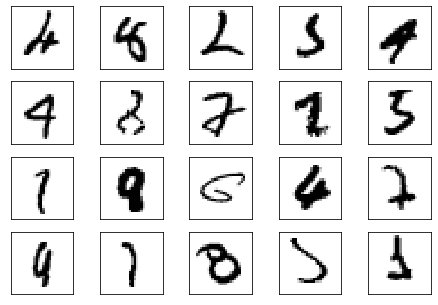

In [3]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

print("calculating test accuracy ... ")
#sampled = 1000
#x_test = x_test[:sampled]
#t_test = t_test[:sampled]

classified_ids = []

acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = network.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1)
    classified_ids.append(y)
    acc += np.sum(y == tt)
    
acc = acc / x_test.shape[0]
print("test accuracy:" + str(acc))

classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()
 
max_view = 20
current_view = 1

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

mis_pairs = {}
for i, val in enumerate(classified_ids == t_test):
    if not val:
        ax = fig.add_subplot(4, 5, current_view, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        mis_pairs[current_view] = (t_test[i], classified_ids[i])
            
        current_view += 1
        if current_view > max_view:
            break

print("======= misclassified result =======")
print("{view index: (label, inference), ...}")
print(mis_pairs)

plt.show()

In [4]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from deep_convnet import DeepConvNet
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

sampled = 10000 # 고속화를 위한 표본추출
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("caluculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16(반정밀도)로 형변환
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)

print("caluculate accuracy (float16) ... ")
print(network.accuracy(x_test, t_test))

caluculate accuracy (float64) ... 
0.9915
caluculate accuracy (float16) ... 
0.9915
